In [1]:
import numpy as np
import json
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from FastMap import FastMap, show_cluster, distance
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from sklearn.manifold import TSNE
from radar import radar_plt

In [2]:
data = np.load('vec_data.npz')

In [3]:
vectors = []
labels = []
names = []
univs = []

for idx, label in enumerate(data):
    univ = data[label][()]
    univs.append(label)
    for name in univ:
        vectors.append(univ[name])
        labels.append(idx)
        names.append(name)
        
vectors = np.asarray(vectors)
vectors = normalize(vectors)

In [4]:
k = 100
kmeans = KMeans(n_clusters=k, random_state=0).fit(vectors)

In [5]:
count = np.zeros((len(univs), k))

cluster = {}
cluster_vec = np.zeros((k, vectors.shape[1]))
for i in range(k):
    cluster[i] = []

for (idx, (univ, clst)) in enumerate(zip(labels, kmeans.labels_)):
    count[univ][clst] += 1
    cluster[clst].append(names[idx])
    cluster_vec[clst] += vectors[idx]

cluster_vec = cluster_vec / np.sum(count, axis=0)[:, None]

with open('cluster.json', 'w') as fp:
    json.dump(cluster, fp)

In [6]:
discipline = np.load('vec_discipline.npz')

In [7]:
discipline_vec = []
discs = []

for idx, disc in enumerate(discipline):
    discipline_vec.append(discipline[disc])
    discs.append(disc)
        
discipline_vec = np.asarray(discipline_vec)
discipline_vec = normalize(discipline_vec)

In [8]:
cos_sim = 1 - pairwise_distances(cluster_vec, discipline_vec, metric="cosine")
cos_sim = normalize(cos_sim, axis=0)
tags = np.argmax(cos_sim, axis=1)

In [9]:
rcount = np.zeros((len(univs), len(discs)))
rcluster = {}
rlabels = []

for i in discs:
    rcluster[i] = []

for idx in range(k):
    for univ in range(len(univs)):
        rcount[univ][tags[idx]] += count[univ][idx]
    rcluster[discs[tags[idx]]] += cluster[idx]

for label in kmeans.labels_:
    rlabels.append(tags[label])

with open('rcluster.json', 'w') as fp:
    json.dump(rcluster, fp)

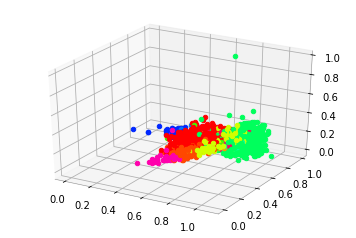

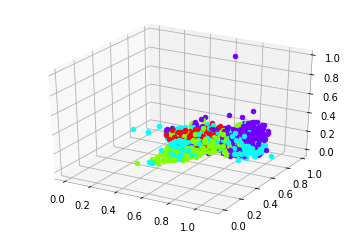

In [12]:
d = 3
dist = euclidean_distances(vectors, vectors)
X2, _ = FastMap(d, dist, vectors.shape[0])
show_cluster(X2, rlabels, d)
show_cluster(X2, labels, d)

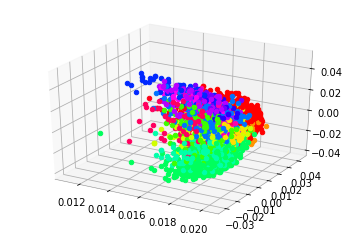

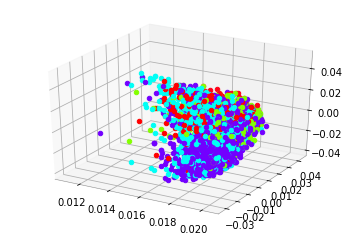

In [13]:
d = 3
pca = PCA(n_components=d)
pca.fit_transform(vectors.T)
show_cluster(pca.components_.T, rlabels, d)
show_cluster(pca.components_.T, labels, d)

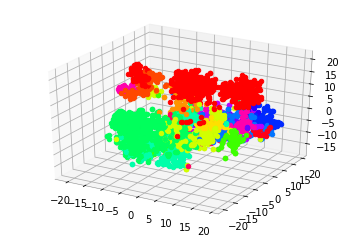

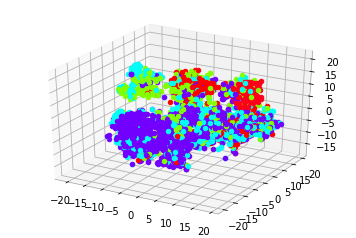

In [14]:
d = 3
tsne = TSNE(n_components=d, random_state=0)
tsne.fit_transform(vectors)
show_cluster(tsne.embedding_, rlabels, d)
show_cluster(tsne.embedding_, labels, d)

In [10]:
strength = normalize(rcount, axis=0)
strength /= np.max(strength, axis=1)[:, None]
strength *=  100

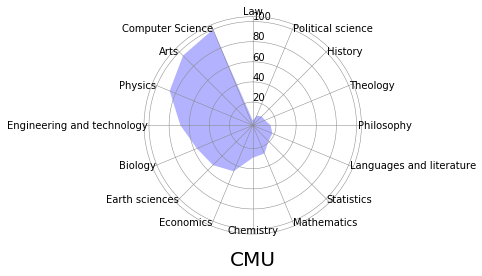

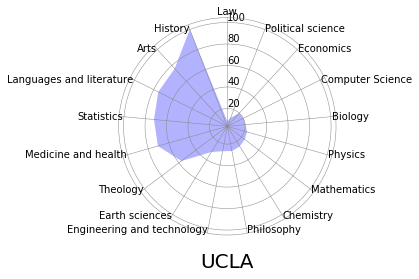

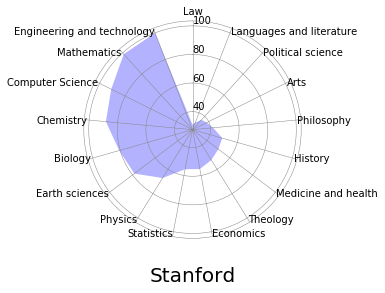

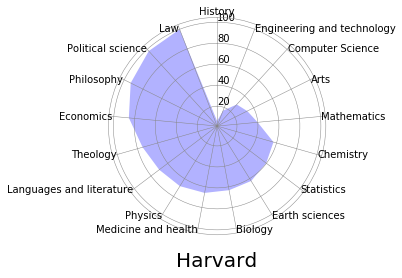

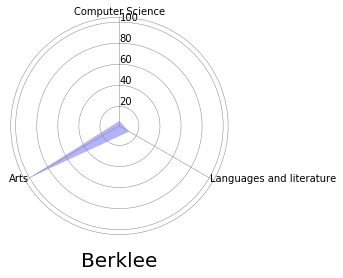

In [11]:
for j in range(strength.shape[0]):
    values = strength[j]
    idxs = np.argsort(values)
    cat = [discs[i] for i in idxs]
    values = np.sort(values)
    tail = len(values) - len(np.nonzero(values)[0])
    cat = cat[tail:]
    values = list(values[tail:])
    radar_plt(cat, values, univs[j])